In [2]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder_wsindy import full_network
from training_wsindy import create_feed_dictionary, create_feed_dictionary2, eval_model, max_err_heatmap
from sindy_utils import *
from error_utils import *
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import time
from copy import deepcopy
import subprocess as sp
%matplotlib inline
import random
from sklearn.linear_model import LinearRegression
import copy

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 13254
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 14453
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16125
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 13373


In [4]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='2'))

## Load the Trained WgLaSDI

In [5]:
data_path = os.getcwd() + '/fig/nDI1/'
save_name = 'ex9_2024_07_04_11_28_03'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
params['config'] = config
print(params['widths'],params['activation'])
print(params['loss_weight_decoder'],params['loss_weight_wsindy_x'],params['loss_weight_wsindy_z'],params['loss_weight_wsindy_regularization'])
print(params['epoch_count'])
print(params['L'])

[100] relu
1.0 1 1 0.0001
30000
10


## Evaluation by One Parameter Case

In [6]:
knn = 1
w1 = 1.5
w2 = 2
tstop = 3
t_test = tstop
test_data = pickle.load(open(f"/g/g92/he10/Research/data/MFEMex9/local1_p1{w1:.1f}_p2{w2:.1f}_tstop{tstop:.1f}.p", "rb"))
nt = test_data['data'][0]['x'].shape[0]
t = np.linspace(0,t_test,nt)

# discretization coordinates
vert = np.loadtxt('/g/g92/he10/Research/data/MFEMex9/vertex.txt')
triang = tri.Triangulation(vert[:,0], vert[:,1])

test_data_x = test_data['data'][0]['x']
test_data_dx = test_data['data'][0]['dx']

(301, 3) (301, 9216) (301, 9216)


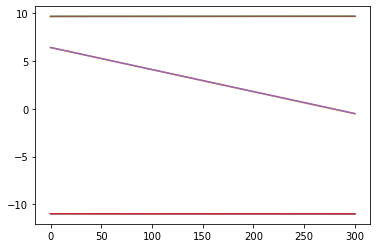

In [7]:
u_decoder,du_decoder,u_sim,du_sim,z_encoder,dz_encoder,z_sim,dz_sim,idx,timer_rom = eval_model(test_data['data'][0], params,
                                                                                               test_data['param'][0], knn=knn,
                                                                                               calc_dz=True, calc_du=True)
u_decoder = u_decoder.squeeze()
print(z_sim.shape, u_sim.shape, u_decoder.shape)

In [8]:
# max relative error
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 1.52 %
max sindy-decoder error: 1.49 %


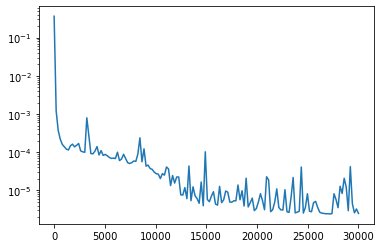

In [9]:
loss = []
for i in range(len(params['training_losses'])):
    loss.append(params['training_losses'][i][0])
xp = np.linspace(1,params['epoch_count'],len(params['training_losses']))
plt.plot(xp,loss)
# plt.ylim([9e-2, 6e-1])
# plt.xlim([3e4, 4.6e4])
# plt.ylim([min(loss), 8e-1])
plt.yscale('log')

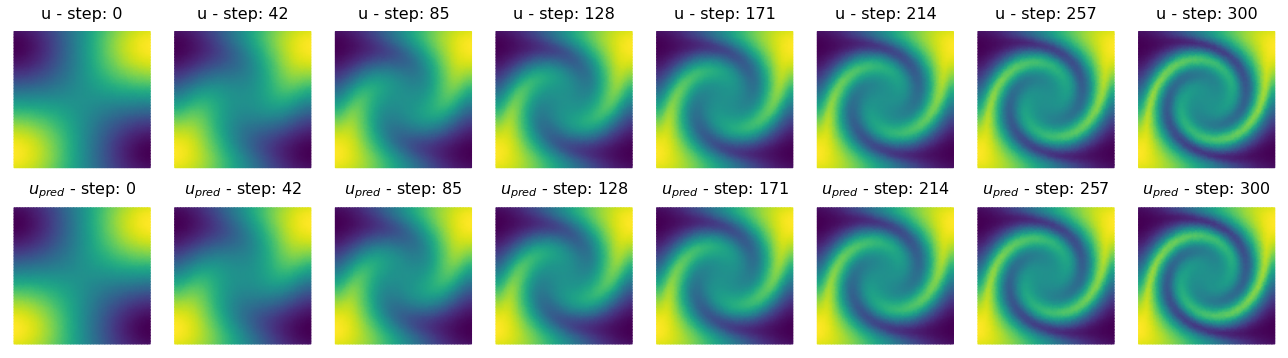

In [10]:
nstep = 8
step_list = np.linspace(0,nt-1,nstep).astype(int)
vmin_x = test_data_x.min()
vmax_x = test_data_x.max()
vmin_dx = test_data_dx.min()/10
vmax_dx = test_data_dx.max()/10

fig = plt.figure(figsize=(18,10))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1)
    ax.tripcolor(triang, test_data_x[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'u - step: {step}', fontsize=16)
    ax.set_aspect('equal')
    plt.axis('off')
plt.tight_layout()

for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+nstep)
    ax.tripcolor(triang, u_sim[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(r'$u_{pred}$' + f' - step: {step}', fontsize=16)
    ax.set_aspect('equal')
    plt.axis('off')
plt.tight_layout()
plt.savefig(data_path + f"inter_pred_multisteps.png")

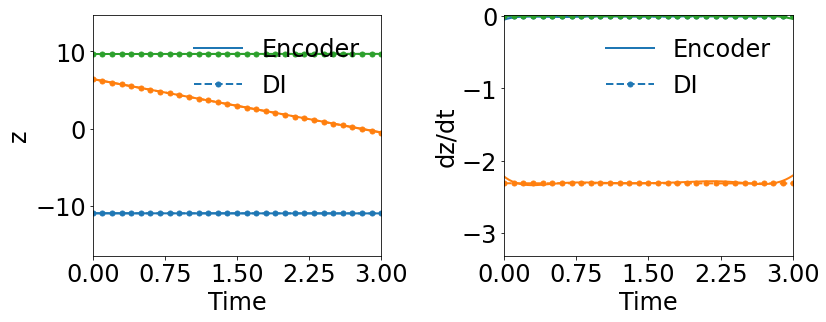

In [11]:
plt.rcParams.update({"font.size": 24,
                     "font.family": "sans-serif"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.5,z_sim.max()+5)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()-1,dz_sim.max()*3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)

plt.tight_layout()
plt.savefig(data_path + f"advection_latent_dynamics.png",bbox_inches='tight')

## Evaluation by the Prescribed Parameter Space

In [11]:
params['pde']['u_file'] = './ex9-u_pred11.gf'
params['pde']['res_file'] = "./ex9-residual11.gf"

In [12]:
knn = 3
res_name = f'mean'

na = 21
nw = na
p1_test = np.linspace(1.5, 2, na)
p2_test = np.linspace(2, 2.5, nw)
num_case = p1_test.size * p2_test.size
max_err = np.zeros([len(p1_test), len(p2_test)])
res_norm = np.zeros([len(p1_test), len(p2_test)])
sindy_idx = np.zeros([len(p1_test), len(p2_test)])
test_data_all = pickle.load(open(f"/g/g92/he10/Research/data/MFEMex9/local{num_case}_tstop{tstop:.1f}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(p1_test):
    for j,w in enumerate(p2_test):
        print(f"{count}/{num_case}: {test_data_all['param'][count]}")
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        
        _,_,u_sim,_,_,_,_,_,idx,t_rom = eval_model(test_data['data'][0], params, 
                                                   test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # Max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data['data'][0]['x'] - u_sim, axis=1) \
                        / np.linalg.norm(test_data['data'][0]['x'], axis=1)*100).max()
        
        # residual norm
        params['pde']['param'] = [a, w] # the parameter values of the testing case
        res_norm[i,j] = err_indicator(u_sim, params, err_type=params['err_type'])
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.8 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err.max() :.2f} %')
print(f'Average speed up: {speed_up:.2f}')

0/441: [1.5 2. ]
1/441: [1.5   2.025]
2/441: [1.5  2.05]
3/441: [1.5   2.075]
4/441: [1.5 2.1]
5/441: [1.5   2.125]
6/441: [1.5  2.15]
7/441: [1.5   2.175]
8/441: [1.5 2.2]
9/441: [1.5   2.225]
10/441: [1.5  2.25]
11/441: [1.5   2.275]
12/441: [1.5 2.3]
13/441: [1.5   2.325]
14/441: [1.5  2.35]
15/441: [1.5   2.375]
16/441: [1.5 2.4]
17/441: [1.5   2.425]
18/441: [1.5  2.45]
19/441: [1.5   2.475]
20/441: [1.5 2.5]
21/441: [1.525 2.   ]
22/441: [1.525 2.025]
23/441: [1.525 2.05 ]
24/441: [1.525 2.075]
25/441: [1.525 2.1  ]
26/441: [1.525 2.125]
27/441: [1.525 2.15 ]
28/441: [1.525 2.175]
29/441: [1.525 2.2  ]
30/441: [1.525 2.225]
31/441: [1.525 2.25 ]
32/441: [1.525 2.275]
33/441: [1.525 2.3  ]
34/441: [1.525 2.325]
35/441: [1.525 2.35 ]
36/441: [1.525 2.375]
37/441: [1.525 2.4  ]
38/441: [1.525 2.425]
39/441: [1.525 2.45 ]
40/441: [1.525 2.475]
41/441: [1.525 2.5  ]
42/441: [1.55 2.  ]
43/441: [1.55  2.025]
44/441: [1.55 2.05]
45/441: [1.55  2.075]
46/441: [1.55 2.1 ]
47/441: [1.55  2

In [13]:
max_err.mean()

2.2288157317422654

In [14]:
a_grid, w_grid = np.meshgrid(p1_test, p2_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])
a_grid, w_grid = np.meshgrid(np.arange(p1_test.size), np.arange(p2_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

In [15]:
# max_err2 = max_err + 0.7

number of DI: 16
idx: 0, param: [1.5 2. ]
idx: 420, param: [1.5 2.5]
idx: 20, param: [2. 2.]
idx: 440, param: [2.  2.5]
idx: 221, param: [1.775 2.25 ]
idx: 272, param: [2.  2.3]
idx: 273, param: [1.5   2.325]
idx: 330, param: [1.875 2.375]
idx: 14, param: [1.85 2.  ]
idx: 146, param: [2.   2.15]
idx: 409, param: [1.75  2.475]
idx: 147, param: [1.5   2.175]
idx: 6, param: [1.65 2.  ]
idx: 215, param: [1.625 2.25 ]
idx: 341, param: [1.625 2.4  ]
idx: 94, param: [1.75 2.1 ]


../../src/training.py:704: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


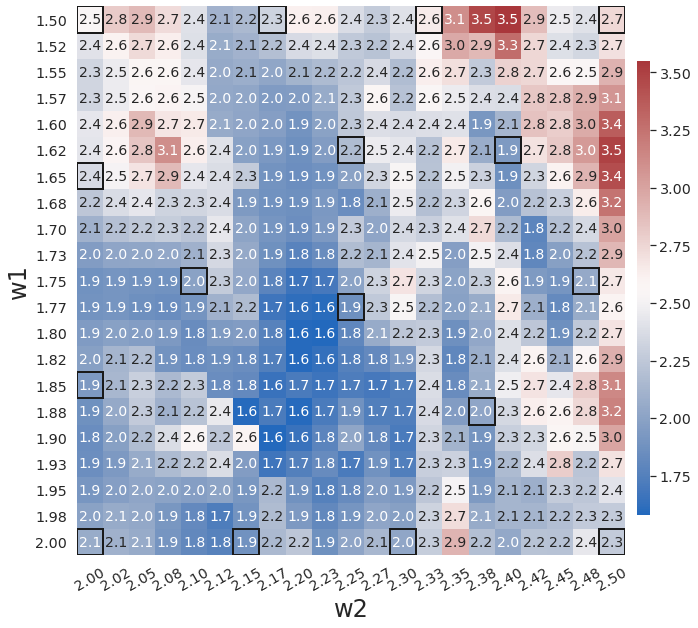

In [17]:
print(f"number of DI: {params['num_wsindy']}")
max_err_heatmap(max_err, sindy_idx, params, p1_test, p2_test, data_path, idx_list, idx_param,
                xlabel='w2', ylabel='w1', dtype='float')